In [5]:
import pandas as pd
from pandas_datareader import data, wb
import numpy as np
import matplotlib.pyplot as plt
import quandl
%matplotlib inline

In [6]:
# download Dax data from the start of 2015 and store in a Pandas DataFrame
df = quandl.get("CHRIS/EUREX_FDAX1", authtoken="5GGEggAyyGa6_mVsKrxZ", start_date="2015-01-01")

In [7]:
df.head()

,Open,High,Low,Settle,Volume,Prev. Day Open Interest
Date,,,,,,
2015-01-02,9797.5,9891.0,9692.5,9768.5,78835.0,126100.0
2015-01-05,9726.5,9796.0,9450.5,9477.5,142919.0,127377.0
2015-01-06,9475.0,9631.5,9383.5,9491.5,149371.0,128386.0
2015-01-07,9510.0,9611.5,9463.0,9502.5,116841.0,127975.0
2015-01-08,9658.0,9863.0,9613.0,9850.0,132833.0,129657.0


In [8]:
# Set number of days and standard deviations to use for rolling lookback period for Bollinger band calculation
window = 21
no_of_std = 2

# Calculate rolling mean and standard deviation using number of days set above
rolling_mean = df['Settle'].rolling(window).mean()
rolling_std = df['Settle'].rolling(window).std()

# Create two new DataFrame columns to hold values of upper and lower Bollinger bands
df['Rolling Mean'] = rolling_mean
df['Bollinger High'] = rolling_mean + (rolling_std * no_of_std)
df['Bollinger Low'] = rolling_mean - (rolling_std * no_of_std)

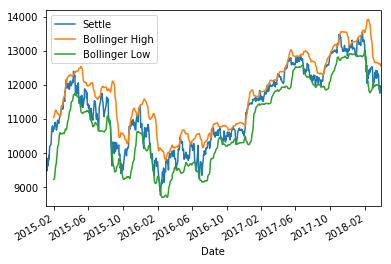

In [9]:
df[['Settle', 'Bollinger High', 'Bollinger Low']].plot()

In [17]:
# Create an "empty" column as a placeholder for our /position signals
df['Position'] = None
df.columns.get_loc('Position')
#df.columns

9

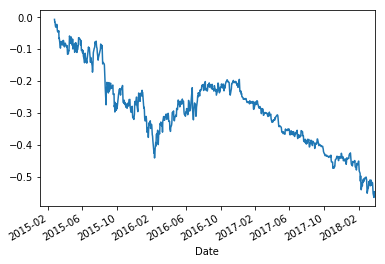

In [19]:

# Fill our newly created position column - set to sell (-1) when the price hits the upper band,...
# ...and set to buy (1) when it hits the lower band
for row in range(len(df)):
    
    if ((df['Settle'].iloc[row] > df['Bollinger High'].iloc[row]) and 
    (df['Settle'].iloc[row-1] < df['Bollinger High'].iloc[row-1])):
        #df['Position'].iloc[row] = -1
        # Changed to below to avoid the SettingWithCopyWarning found at
        # http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
        df.iloc[row, df.columns.get_loc('Position')] = -1
        
    if ((df['Settle'].iloc[row] < df['Bollinger Low'].iloc[row]) and 
    (df['Settle'].iloc[row-1] > df['Bollinger Low'].iloc[row-1])):
        #df['Position'].iloc[row] = 1
        # Changed to below to avoid the SettingWithCopyWarning found at
        # http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
        df.iloc[row, df.columns.get_loc('Position')] = 1
        
        
# Forward fill our position column to replace the "None" values with the correct long/short positions to...
# ...represent the "holding" for our positions forward through time
df['Position'].fillna(method='ffill', inplace=True)

# Calculate the daily market return and multiply that by the position to determine strategy returns
df['Market Return'] = np.log(df['Settle'] / df['Settle'].shift(1))
df['Strategy Return'] = df['Market Return'] * df['Position']

# Plot the strategy returns
df['Strategy Return'].cumsum().plot()
        

In [20]:
# Define a Bollinger Band trading strategy function that we can easily reuse with varying inputs
def bollinger_strat(df, window, std):
    rolling_mean = df['Settle'].rolling(window).mean()
    rolling_std = df['Settle'].rolling(window).std()
    
    df['Bollinger High'] = rolling_mean + (rolling_std * std)
    df['Bollinger Low'] = rolling_mean - (rolling_std * std)
    
    df['Short'] = None
    df['Long'] = None
    df['Position'] = None
    
    for row in range(len(df)):
        if ((df['Settle'].iloc[row] > df['Bollinger High'].iloc[row]) and
                (df['Settle'].iloc[row-1] < df['Bollinger High'].iloc[row-1])):
            #df['Position'].iloc[row] = -1
            # Changed to below to avoid the SettingWithCopyWarning found at
            # http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
            df.iloc[row, df.columns.get_loc('Position')] = -1
            
            
        if ((df['Settle'].iloc[row] < df['Bollinger Low'].iloc[row]) and
               (df['Settle'].iloc[row-1] > df['Bollinger Low'].iloc[row-1])):
            #df['Position'].iloc[row] = 1
            # Changed to below to avoid the SettingWithCopyWarning found at
            # http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
            df.iloc[row, df.columns.get_loc('Position')] = 1
            
            
    df['Position'].fillna(method='ffill', inplace=True)
    
    df['Market Return'] = np.log(df['Settle'] / df['Settle'].shift(1))
    df['Strategy Return'] = df['Market Return'] * df['Position']
    
    df['Strategy Return'].cumsum().plot()

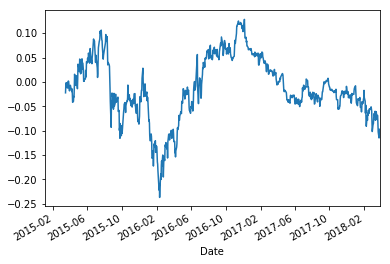

In [21]:
bollinger_strat(df, 50, 2)

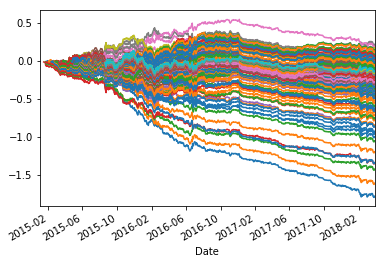

In [22]:
# Check to see if there are any lookback periods that will generate a positive return
# Set up "daily lookback period" and "number of standard deviation" vectors
# For example the first one creates a vector of 20 evenly spaced integer values ranging from 10 to 100
# The second creates a vector of 10 evenly spaced floating point numbers from 1 to 3
windows = np.linspace(10,100,20,dtype=int)
stds = np.linspace(1,3,10)

# And iterate through them both, running the strategy function each time
for window in windows:
    for std in stds:
        bollinger_strat(df,window,std)